In [27]:
import pandas as pd
import pandas_datareader.data as pdr
from datetime import datetime
import yfinance as yf
import numpy as np
import talib as tb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler

from skopt import BayesSearchCV 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import xgboost as xgb
from code_.backtester import Backtester

In [2]:
plt.rcParams['figure.figsize'] = 15, 7

# 1. Data Retrieval
### Specify query parameters

In [382]:
symbol ='BTC-USD'
#symbol ='QQQ'

start = datetime(2014, 1, 1)
end = datetime(2020, 10, 4)

### Get data using Yahoo API

In [383]:
stock = pdr.get_data_yahoo(symbol, start, end, interval='d')
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


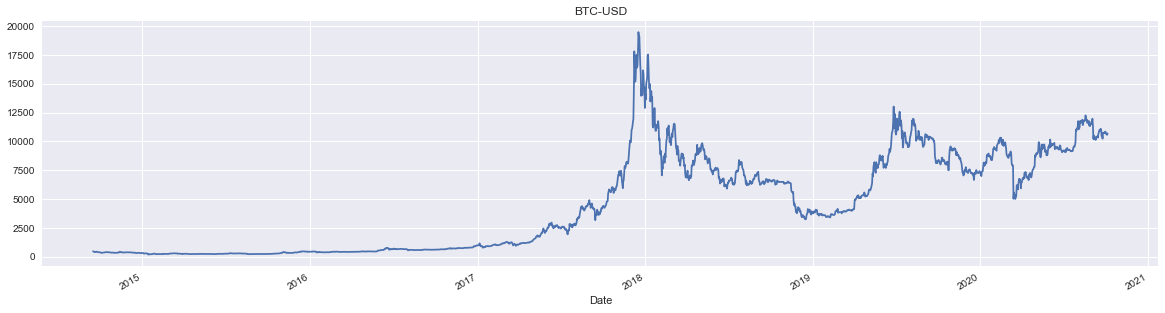

In [384]:
stock.columns = list(stock.columns.str.lower())
stock['volume'] = stock['volume'].astype(float)
stock['open'].plot(figsize=(20,5), title=f'{symbol}'), plt.show();

### Data Transformation: labelling and TA features

In [423]:
#specify forecasting parameters
price_change_threshold = 1.06

In [424]:
def classify(current, future):

    if float(future) > float(current*price_change_threshold):  # if the future price is SUFFICIENTLY higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0   
    
def label_data(data, future_periods):

    data['future'] = data["high"].shift(-future_periods)
    data['target'] = list(map(classify, data["high"], data['future']))
    return data

class ColumnExtractor(object):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [425]:
labelled_data = label_data(stock, 1)

In [426]:
#check class imbalance
labelled_data.groupby('target').count()

,high,low,open,close,volume,adj close,future
target,,,,,,,
0,2104,2104,2104,2104,2104,2104,2103
1,106,106,106,106,106,106,106


In [427]:
#Technical features
high = labelled_data['high'].values
low = labelled_data['low'].values
volume = labelled_data['volume'].values
# define the technical analysis matrix
retn = np.array([
    tb.MA(high, timeperiod=5),                                         # 1
    tb.MA(high, timeperiod=10),                                        # 2
    tb.MA(high, timeperiod=20),                                        # 3
    tb.MA(high, timeperiod=60),                                        # 4
    tb.MA(high, timeperiod=90),                                        # 5
    tb.MA(high, timeperiod=120),                                       # 6

    tb.MACD(high, fastperiod=12, slowperiod=26, signalperiod=9)[0],    # 9
    tb.RSI(high, timeperiod=14),                                       # 10

    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0],  # 11
    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1],  # 12
    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]

]).T

retdf = pd.DataFrame(retn)
retdf['date'] = labelled_data.index.values
retdf.set_index('date', inplace=True)
expanded_data = labelled_data.join(retdf)

In [428]:
#additional features
expanded_data['high_delta'] = expanded_data['high'].pct_change()
expanded_data['vol_delta'] = expanded_data['volume'].pct_change()
expanded_data = expanded_data.replace([np.inf, -np.inf], np.nan).dropna()

In [429]:
X = expanded_data.drop(['future', 'target'], axis=1)
X.columns = [str(col) for col in X.columns]
y = expanded_data['target']

# 2. Modelling

In [430]:
#Split the given training data further so as to validate performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=0,
                                                    shuffle=False,
                                                    test_size=0.15
                                            )

#specify numeric features
numerical_features = X.columns

In [431]:
#numeric transformations
numeric_transformer = Pipeline(steps=[
    ('extract', ColumnExtractor(columns=numerical_features)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True))
])

#categorical transformations
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

#package transformations into another pipe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ])

#define feature selection strategy
clf = ExtraTreesRegressor(n_estimators=100)
reducer = SelectFromModel(clf)

#scaler
scaler = StandardScaler()

#sampler, if there is significant class imbalance
sampler = SMOTE()

#estimator
class_imbalance_weighting = round(len(y_train) / y_train.sum())
estimator = xgb.XGBRFClassifier(no_omp=1,
                                objective='binary:logistic',
                                eval_metric='aucpr',
                                scale_pos_weight=class_imbalance_weighting)

#pack it up
mdl = imbPipeline(steps=[('preprocessor', preprocessor),
                         ('reducer', reducer),
                         ('scaler', scaler),
                         #('sampler', sampler),
                         ('estimator', estimator)])

### Tune hyperparameters

In [432]:
#Define search space
# n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
# max_depth = [int(x) for x in np.linspace(4, 20, num=10)]
# learning_rate = [float(x) for x in np.linspace(start=0.005, stop=0.1, num=10)]
# gamma = [float(x) for x in np.linspace(start=0, stop=0.4, num=10)]
# min_child_weight = [float(x) for x in np.linspace(start=0, stop=10, num=10)]
# colsample_by_tree = [0.3, 0.5, 0.7, 1]

#Using small search space for debugging
param_grid  = {
                'estimator__learning_rate': (0.01, 1.0, 'log-uniform'),
                'estimator__min_child_weight': (0.1, 10),
                'estimator__max_depth': (2, 50),
                'estimator__max_delta_step': (2, 20),
                'estimator__colsample_bytree': (0.01, 1.0, 'uniform'),
                'estimator__gamma': (1e-9, 0.5, 'log-uniform'),
                'estimator__n_estimators': (100, 150)
}

tuner = BayesSearchCV(estimator=mdl,
                      search_spaces=param_grid,
                      n_iter=10,
                      cv=4,
                      scoring='average_precision',
                      n_jobs=-1,
                      verbose=1)

tuner.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.7s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.0s finished


BayesSearchCV(cv=4,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('extract',
                                                                                           <__main__.ColumnExtractor object at 0x0000026406BBA548>),
                                                                                          ('poly',
                                                                                           PolynomialFeatures(interaction_only=True))]),
                                                                          Index(['high', 'low', 'open', 'close', 'volume', 'adj close', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', 'high_delta', 'vo...
              n_iter=10, n_jobs=-1, scoring='average_precision',
              search_spaces={'estimator__colsample_bytree': (0.01, 1.0

#### Evaluate model

In [433]:
y_pred = tuner.predict(X_test)

print(f'overall_acc: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')

overall_acc: 0.8924050632911392
precision: 0.11764705882352941
F1: 0.19047619047619047


In [434]:
tuner.best_params_

OrderedDict([('estimator__colsample_bytree', 0.0389230627202187),
             ('estimator__gamma', 0.3611933611331183),
             ('estimator__learning_rate', 0.014824374316438115),
             ('estimator__max_delta_step', 12),
             ('estimator__max_depth', 19),
             ('estimator__min_child_weight', 6.697038757160592),
             ('estimator__n_estimators', 141)])

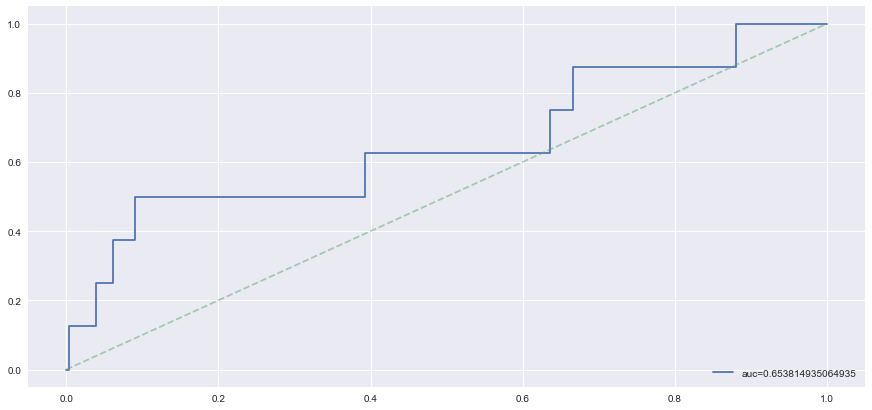

In [435]:
y_pred_proba = tuner.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
ident = [0.0, 1.0]
plt.plot(ident,ident, linestyle='--', alpha=0.5)
plt.legend(loc=4)
plt.show()

In [436]:
y_comparisons = pd.DataFrame()
y_comparisons['y_test'] = y_test
y_comparisons['y_pred'] = y_pred

y_comparisons.head()

,y_test,y_pred
2019-11-25,0,0
2019-11-26,0,0
2019-11-27,0,0
2019-11-28,0,0
2019-11-29,0,0


In [437]:
#join prediction data to price and date data
#index_name = 'Date'
index_name = 'index'

historical_price_prediction_data = (pd.merge(X_test, expanded_data.reset_index()[[index_name, 'open', 'high', 'low', 'close', 'volume']],
                                            how='inner',
                                            on=['open', 'high', 'low', 'close', 'volume'])
                                     .set_index(index_name))

historical_price_prediction_data = historical_price_prediction_data.join(y_comparisons, how='inner')[['open', 'high', 'low', 'close', 'volume', 'y_test', 'y_pred']]
historical_price_prediction_data.sort_index(inplace=True)
historical_price_prediction_data.head()

,open,high,low,close,volume,y_test,y_pred
2019-11-25,7039.977051,7319.856934,6617.166992,7146.133789,4.268523e+10,0,0
2019-11-26,7145.159180,7320.230469,7098.572266,7218.371094,2.112951e+10,0,0
2019-11-27,7220.880859,7619.693359,6974.174316,7531.663574,2.399141e+10,0,0
2019-11-28,7536.820312,7730.072754,7454.121582,7463.105957,1.905012e+10,0,0
2019-11-29,7466.727051,7781.179688,7460.756348,7761.243652,1.970970e+10,0,0


In [438]:
historical_price_prediction_data.groupby('y_pred').count()

,open,high,low,close,volume,y_test
y_pred,,,,,,
0,310,310,310,310,310,310
1,34,34,34,34,34,34


# 3. Backtest


=================TRADING HISTORY==================
2019-11-25 to 2020-10-3

Number of entries made:  34
Number of losing trades:  32
Expected value per trade:  -70.55734001608457
Max_drawdown:  -123.59056640625
Cumulative loss:  -3195.655615234375
Average loss:  -99.86423797607424
Average gain:  398.35302734375

Overall gain:  -2398.9495605468746


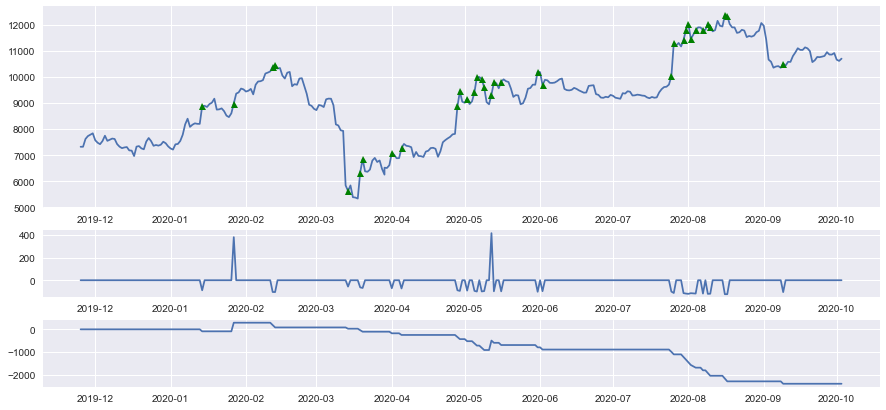

In [448]:
plt.rcParams['figure.figsize'] = 15, 7
bt = Backtester(historical_price_prediction_data, 1, 'buy', price_change_threshold)
bt.nominal_stop_loss = 0
bt.percentage_stop_loss = 0.01

bt.simulate_trades_corrected()
bt.visualize_trades()

In [449]:
#comparison to a buy and hold lol...
print(f'''Overall gain B&H: {historical_price_prediction_data["high"].iloc[-1] 
- historical_price_prediction_data["high"].iloc[0]}''')

Overall gain B&H: 3380.93408203125


In [450]:
bt.trade_record[(bt.trade_record.y_test == 1) &  (bt.trade_record.y_pred == 1)]

,open,high,low,close,volume,y_pred,y_test,price_today,price_next_period,eod_price_next_period,predicted_price,actual_price_change,predicted_price_change,net_gain,lowest_price_next_period,portfolio_value,decision_outcome,actual_outcome
2020-03-19,5245.416504,6329.735840,5236.968750,6191.192871,5.100073e+10,1,1,6329.735840,6844.261719,6198.778320,6709.519990,514.525879,379.784150,-63.297358,5865.781738,-35.993843,6329.735840,6329.735840
2020-04-28,7806.712402,8871.753906,7786.049316,8801.038086,6.020105e+10,1,1,8871.753906,9440.650391,8658.553711,9404.059141,568.896484,532.305234,-88.717539,8533.255859,-336.754287,8871.753906,8871.753906
2020-05-05,9007.441406,9411.467773,8966.706055,9268.761719,4.937189e+10,1,1,9411.467773,9992.664062,9951.518555,9976.155840,581.196289,564.688066,-94.114678,9138.322266,-616.953281,9411.467773,9411.467773
2020-07-25,9680.234375,10023.807617,9652.847656,9905.166992,2.050800e+10,1,1,10023.807617,11298.221680,10990.873047,10625.236074,1274.414062,601.428457,-100.238076,9903.969727,-991.356621,10023.807617,10023.807617
